In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


In [53]:
!pip install midv500


In [56]:
import midv500


In [39]:
cd /content/drive/MyDrive/abbyy/t1/task1

/content/drive/MyDrive/abbyy/t1/task1


In [40]:
!pip install -e .

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [4]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [5]:
DATASET_PATH = Path().absolute().parent.parent / 'midv500'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [54]:
# set directory for dataset to be downloaded
dataset_dir = 'midv500_data/'


In [57]:

# download and unzip the base midv500 dataset
dataset_name = "midv500"
midv500.download_dataset(dataset_dir, dataset_name)

--------------------------------------------------------------

Downloading: 01_alb_id.zip


01_alb_id.zip:  88%|████████▊ | 581M/657M [00:34<00:04, 16.7MB/s]


KeyboardInterrupt: 

In [6]:
# Собираем список пакетов (MidvPackage)
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(2, course_intro_ocr_t1.data.MidvPackage)

In [7]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_intro_ocr_t1.data.MidvPackage, 300, course_intro_ocr_t1.data.DataItem)

In [23]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 2/2 [04:15<00:00, 127.77s/it]

В 439 из 600 случаев разметка кропа(т.е. документ) целиком в кадре


In [24]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

В 100 из 600 случаев кадр принадлежит к test-split


## Classic CV baseline

### Для работы baseline нужен установленныей OpenCV

In [12]:
import cv2

In [ ]:
!pip install torch torchvision
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

In [15]:
class SamCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        1. Найти Маску, используя текстовый промпт
        2. Найти ключевые точки(КТ) на маске
    """
    def __init__(self):
        self.SAM = LangSAM()



    def get_mask(self, image_pi):
        text_prompt = "document"
        masks = self.SAM.predict(image_pil, text_prompt)
        self.h, self.w, _ = image_pil.shape
        return np.array(masks[0], dtype = int)


    def compute_crop(self, mask):
      contours = cv2.findContours(mask, method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)[0]
      epsilon = 0.1 * cv2.arcLength(contours[0], True)
      approx = cv2.approxPolyDP(contours[0], epsilon, True)
      return approx.reshape((4,2)) / np.array([[ self.w,  self.h]])

    def res(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        m = self.get_mask(query_image)
        c = self.compute_crop(m)
        return c

In [31]:
w

450

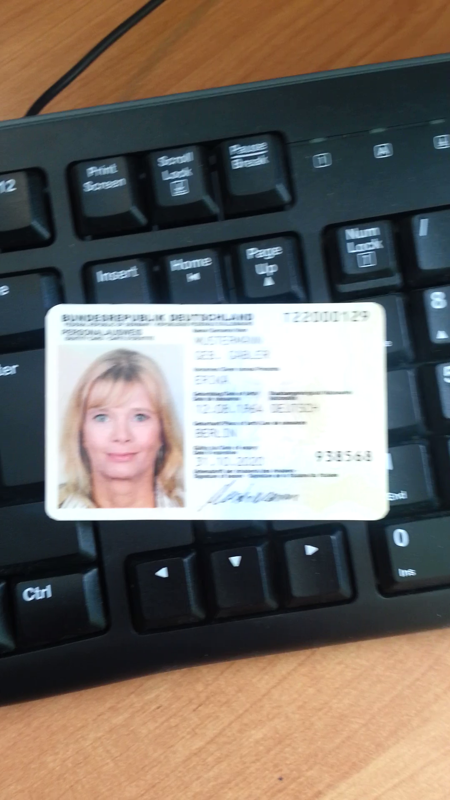

In [28]:
data_packs[0][1].image.convert("RGB")

In [32]:
image_pil = data_packs[0][1].image.convert("RGB")
w, h = data_packs[0][1].image.size
text_prompt = "document"
masks, boxes, phrases, logits =  model.predict(image_pil, text_prompt)
mask = np.array(masks[0], dtype = int)

contours = cv2.findContours(mask, method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)[0]
epsilon = 0.1 * cv2.arcLength(contours[0], True)
approx = cv2.approxPolyDP(contours[0], epsilon, True)
crop = approx.reshape((4,2)) / np.array([[ w,  h]])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [33]:
crop

array([[0.84888889, 0.38375   ],
       [0.84666667, 0.6475    ],
       [0.1       , 0.63875   ],
       [0.11777778, 0.3825    ]])

In [16]:
from PIL import Image
from lang_sam import LangSAM

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
a = SamCrop()

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [20]:
model = LangSAM()


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:14<00:00, 182MB/s]


In [ ]:
results_dict = dict()

for dp in tqdm(data_packs):
    bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(np.array(dp[i].image))
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0

In [22]:
model.predict(data_packs[1][2].image, "document")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


(tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]]),
 tensor([[ 62.5768, 281.3673, 438.9930, 552.6803]]),
 ['document'],
 tensor([0.8824]))

In [8]:

model = LangSAM()
image_pil = Image.open('/content/drive/MyDrive/abbyy/eee.jpeg').convert("RGB")
text_prompt = "document"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:18<00:00, 140MB/s] 
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.w

In [17]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

In [ ]:
pred_quad = bcm(np.array(dp[0].image))

In [ ]:
pred_quad, dp[0].quadrangle

(array([[0.16024225, 0.35054744],
        [0.96535159, 0.37063301],
        [0.97013904, 0.68652287],
        [0.13752121, 0.68880732]]),
 array([[0.16      , 0.35125   ],
        [0.96666667, 0.36625   ],
        [0.97777778, 0.6875    ],
        [0.13555556, 0.69      ]]))

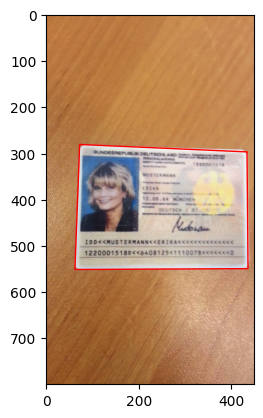

In [ ]:
dp[0].show(pred_quad)

In [40]:
data_packs[0][7].image

'14_deu_id_new|ground_truth|KS|KS14_09.json'

In [44]:
a

In [ ]:
image_pil = data_packs[0][1].image.convert("RGB")
w, h = data_packs[0][1].image.size
text_prompt = "document"
masks, boxes, phrases, logits =  model.predict(image_pil, text_prompt)
mask = np.array(masks[0], dtype = int)

contours = cv2.findContours(mask, method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)[0]
epsilon = 0.1 * cv2.arcLength(contours[0], True)
approx = cv2.approxPolyDP(contours[0], epsilon, True)
crop = approx.reshape((4,2)) / np.array([[ w,  h]])

In [34]:
results_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                image_pil = dp[i].image.convert("RGB")
                w, h = dp[i].image.size
                text_prompt = "document"
                masks, boxes, phrases, logits =  model.predict(image_pil, text_prompt)
                mask = np.array(masks[0], dtype = int)
                contours = cv2.findContours(mask, method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)[0]
                epsilon = 0.1 * cv2.arcLength(contours[0], True)
                approx = cv2.approxPolyDP(contours[0], epsilon, True)
                crop = approx.reshape((4,2)) / np.array([[ w,  h]])
                results_dict[dp[i].unique_key] = crop
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)


  0%|          | 0/2 [00:00<?, ?it/s]

cannot reshape array of size 6 into shape (4,2)
cannot reshape array of size 4 into shape (4,2)


 50%|█████     | 1/2 [03:32<03:32, 212.09s/it]

cannot reshape array of size 2 into shape (4,2)


100%|██████████| 2/2 [06:53<00:00, 206.81s/it]


In [46]:
image_pil = data_packs[1][8].image.convert("RGB")
w, h = data_packs[1][8].image.size
text_prompt = "document"
masks, boxes, phrases, logits =  model.predict(image_pil, text_prompt)
mask = np.array(masks[0], dtype = int)
contours = cv2.findContours(mask, method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)[0]
epsilon = 0.1 * cv2.arcLength(contours[0], True)
approx = cv2.approxPolyDP(contours[0], epsilon, True)
crop = approx.reshape((4,2))
results_dict[data_packs[1][8].unique_key] = crop / np.array([[ w,  h]])
# Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0


[[ 80 285]
 [436 293]
 [444 544]
 [ 73 548]]


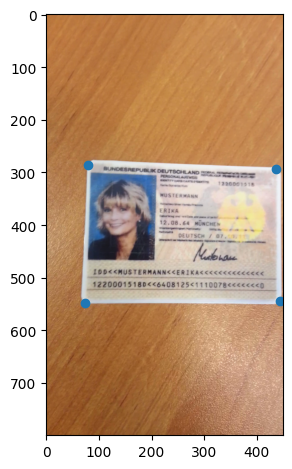

In [49]:
display_image_with_p(image_pil, crop)

[[[ 80 285]]

 [[436 293]]

 [[444 544]]

 [[ 73 548]]]


IndexError: index 1 is out of bounds for axis 1 with size 1

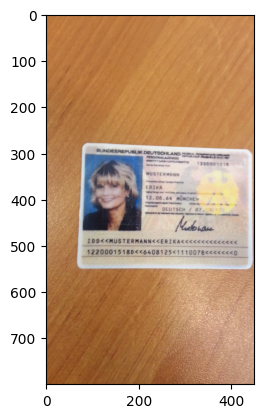

In [48]:

def display_image_with_p(image, p):

    print(p)
    plt.imshow(image)
    plt.scatter(p[:,0], p[:,1])

    plt.tight_layout()
    plt.show()

display_image_with_p(image_pil, approx)

In [ ]:
a = SamCrop()

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [54]:
a.SAM

AttributeError: type object 'SamCrop' has no attribute 'SAM'

In [35]:
results_dict

{'14_deu_id_new|ground_truth|KS|KS14_30.json': array([[0.82444444, 0.38375   ],
        [0.82      , 0.60375   ],
        [0.18      , 0.59125   ],
        [0.21111111, 0.3825    ]]),
 '14_deu_id_new|ground_truth|KS|KS14_27.json': array([[0.84888889, 0.375     ],
        [0.84222222, 0.6125    ],
        [0.18666667, 0.59375   ],
        [0.22222222, 0.375     ]]),
 '14_deu_id_new|ground_truth|KS|KS14_28.json': array([[0.85111111, 0.37875   ],
        [0.84      , 0.61      ],
        [0.19777778, 0.58875   ],
        [0.23111111, 0.3775    ]]),
 '14_deu_id_new|ground_truth|KS|KS14_26.json': array([[0.84222222, 0.3775    ],
        [0.82888889, 0.61875   ],
        [0.16222222, 0.6       ],
        [0.19555556, 0.37375   ]]),
 '14_deu_id_new|ground_truth|KS|KS14_29.json': array([[0.84222222, 0.37875   ],
        [0.83555556, 0.60375   ],
        [0.19555556, 0.5875    ],
        [0.22666667, 0.37875   ]]),
 '14_deu_id_new|ground_truth|PS|PS14_27.json': array([[0.00444444, 0.48375   ],


### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [36]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [37]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [42]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [43]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.0002
